Download a few mta turnstile data files from http://web.mta.info/developers/turnstile.html

In [40]:
!wget http://web.mta.info/developers/data/nyct/turnstile/turnstile_141108.txt

--2015-01-19 08:40:43--  http://web.mta.info/developers/data/nyct/turnstile/turnstile_141108.txt
Resolving web.mta.info... 107.14.41.112, 107.14.41.104
Connecting to web.mta.info|107.14.41.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'turnstile_141108.txt.1'

turnstile_141108.tx     [  <=>                 ]  24.33M  1.57MB/s   in 16s    

2015-01-19 08:41:00 (1.49 MB/s) - 'turnstile_141108.txt.1' saved [25513691]



In [41]:
!wget http://web.mta.info/developers/data/nyct/turnstile/turnstile_141220.txt

--2015-01-19 08:41:00--  http://web.mta.info/developers/data/nyct/turnstile/turnstile_141220.txt
Resolving web.mta.info... 107.14.41.104, 107.14.41.112
Connecting to web.mta.info|107.14.41.104|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: 'turnstile_141220.txt.1'

turnstile_141220.tx     [   <=>                ]  24.04M  1.53MB/s   in 16s    

2015-01-19 08:41:16 (1.47 MB/s) - 'turnstile_141220.txt.1' saved [25208068]



Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like

{    ('A002','R051','02-00-00','LEXINGTON AVE'):    
     [
       ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'],          
       ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'],  
       ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'],
       ...   
     ] 
}

In [42]:
import csv
import sys
d = {}
with open('turnstile_141206.txt', 'r') as turnstile_file:
    reader = csv.reader(turnstile_file)
    reader.next()
    for num, row in enumerate(reader):
        try:
            if num == 5:
                break
            k = tuple(row[:4])
            v = row[4:10]
            v.append(row[10].replace(" ",""))
            if k not in d:
                d[k]=[]
            d[k].append(v)
        except TypeError:
            print >> sys.stderr, 'row %i failed' % num
            
print d

{('A002', 'R051', '02-00-00', 'LEXINGTON AVE'): [['NQR456', 'BMT', '11/29/2014', '03:00:00', 'REGULAR', '0004894443', '0001659781'], ['NQR456', 'BMT', '11/29/2014', '07:00:00', 'REGULAR', '0004894453', '0001659793'], ['NQR456', 'BMT', '11/29/2014', '11:00:00', 'REGULAR', '0004894507', '0001659885'], ['NQR456', 'BMT', '11/29/2014', '15:00:00', 'REGULAR', '0004894735', '0001659947'], ['NQR456', 'BMT', '11/29/2014', '19:00:00', 'REGULAR', '0004895083', '0001660008']]}


For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the cumulative count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil13 module to convert it into a datetime object. For an example check this StackOverflow question11.

Your new dict should look something like

{
('A002','R051','02-00-00','LEXINGTON AVE'):
        [
            [datetime.datetime(2013, 3, 2, 3, 0), 3788],
            [datetime.datetime(2013, 3, 2, 7, 0), 2585],
            [datetime.datetime(2013, 3, 2, 12, 0), 10653],
            [datetime.datetime(2013, 3, 2, 17, 0), 11016],
            [datetime.datetime(2013, 3, 2, 23, 0), 10666],
            [datetime.datetime(2013, 3, 3, 3, 0), 10814],
            [datetime.datetime(2013, 3, 3, 7, 0), 10229],
            ...
          ],
 ....
 }

In [43]:
from datetime import datetime, date, time 
datetime.strptime('11/01/2014'+' '+'13:45:31', '%m/%d/%Y %H:%M:%S')

datetime.datetime(2014, 11, 1, 13, 45, 31)

In [44]:
def load_turnstile_file(ts_file, slot='all', entries=True):
    d = {}
    with open(ts_file, 'r') as turnstile_file:
        reader = csv.reader(turnstile_file)
        reader.next()
        for num, row in enumerate(reader):
            try:
                k = tuple(row[:4])
                if entries==True:
                    v = [datetime.strptime(row[6]+' '+row[7], '%m/%d/%Y %H:%M:%S'),int(row[9])]
                else:
                    v = [datetime.strptime(row[6]+' '+row[7], '%m/%d/%Y %H:%M:%S'),int(row[10].replace(" ",""))]
                if k not in d:
                    d[k]=[]
                if (slot == 'all') or (slot == 'morning' and v[0].hour < 12) or (slot == 'noon' and (v[0].hour > 10 and v[0].hour<16)) or (slot == 'evening' and v[0].hour > 14):
                    d[k].append(v)
            except (TypeError, IndexError):
                print >> sys.stderr, 'row %i failed' % num
    return d


d = load_turnstile_file('turnstile_141220.txt')

These counts are cumulative every n hours. We want total daily entries.
Now make it that we again have the same keys, but now we have a single value for a single day, which is not cumulative counts but the total number of passengers that entered through this turnstile on this day.

In [62]:
#solution A
#1    { (turnstyle):[ [datetime1, counter1], [datetime2, counter2], [datetime3, counter3], ... ] }                d
#2                  [ [day1, counter1], [day1, counter2], [day2, counter3], ... ]                                 .date()
#3                  { day1:[counter1, counter2, ...], day2:[counter3, ...], ... }                                 day_to_cumulcounts
#4                  [ [day1, maxcountersday1 - mincountersday1], [day2, maxcountersday2 - mincountersday2], ...]  daily_count_dict

#solution B
#1    { (turnstyle):[ [datetime1, counter1], [datetime2, counter2], [datetime3, counter3], ... ] }
#2                  [ [day1, counter1, 0, 9999999999], [day1, counter2, 0, 9999999999], [day2, counter3, 0, 9999999999], ... ]
#3                  [ [day1, counter1, mincountersday1, maxcountersday1], [day1, counter2, mincountersday1, maxcountersday1], [day2, counter3, mincountersday2, maxcountersday2], ... ]
#4                  [ [day1, maxcountersday1 - mincountersday1], [day2, maxcountersday2 - mincountersday2], ...]

def solutionA(d):
    daily_count_dict = {}
    for i,j in d.items():
        day_to_cumulcounts = {}
        for v in j:
            day = v[0].date()
            if day not in day_to_cumulcounts:
                day_to_cumulcounts[day] = []
            day_to_cumulcounts[day].append(v[1])
        for day, counts in day_to_cumulcounts.items():
            daily_ridership = max(counts) - min(counts)
            if i not in daily_count_dict:
                daily_count_dict[i]=[]
            daily_count_dict[i].append( (day, daily_ridership))
    return daily_count_dict

In [63]:
# solutionB

def extend_d(d):
    dd = {}
    for i,j in d.items():
        for v in j:
            day = v[0].date()
            c = v[1]
            k = i
            v = [day, c, 99999999999, 0]
            if k not in dd:
                dd[k]=[]
            dd[k].append(v)
    return dd
        
def fill_min_max(dd):
    ddd = {}
    for i,j in dd.items():
        for v in j:
            d,c,mn,mx = v
            for vv in j:
                if vv[0]==d:
                    if mn>vv[1]:
                        mn=vv[1]
                    if mx<vv[1]:
                        mx=vv[1]
            k = i
            v = [d, c, mn, mx]
            if k not in ddd:
                ddd[k]=[]
            ddd[k].append(v)
    return ddd

def keep_diff(ddd):
    dddd = {}
    for i,j in ddd.items():
        for v in j:
            d = v[0]
            c = v[3]-v[2]
            if c > 100000: #if the counter is reset then remove inappropriate result
                c = 0
            k = i
            v = [d, c]
            if k not in dddd:
                dddd[k]=[]
            if v not in dddd[k]:
                dddd[k].append(v)
    return dddd

In [64]:
dddd = keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt'))))

ddddm = keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt', 'morning'))))

ddddn = keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt', 'noon'))))

dddde = keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt', 'evening'))))

dddd2 = keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141018.txt'))))

In [65]:
ddddA = solutionA(load_turnstile_file('turnstile_141108.txt'))

print dddd.items()[0]
print ddddA.items()[0]

(('A030', 'R083', '01-06-00', '23 ST-5 AVE'), [[datetime.date(2014, 11, 1), 1003], [datetime.date(2014, 11, 2), 979], [datetime.date(2014, 11, 3), 2387], [datetime.date(2014, 11, 4), 2472], [datetime.date(2014, 11, 5), 2585], [datetime.date(2014, 11, 6), 2641], [datetime.date(2014, 11, 7), 2538]])
(('A030', 'R083', '01-06-00', '23 ST-5 AVE'), [(datetime.date(2014, 11, 1), 1003), (datetime.date(2014, 11, 6), 2641), (datetime.date(2014, 11, 7), 2538), (datetime.date(2014, 11, 4), 2472), (datetime.date(2014, 11, 5), 2585), (datetime.date(2014, 11, 2), 979), (datetime.date(2014, 11, 3), 2387)])


We will plot the daily time series for a turnstile.

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts.

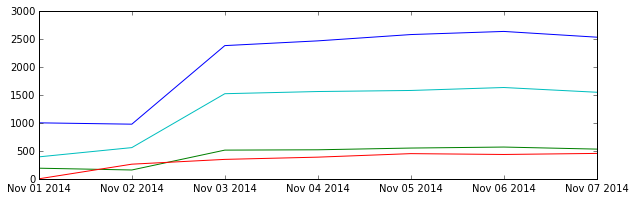

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

a,b = dddd.items()[0]

am,bm = ddddm.items()[0]

an,bn = ddddn.items()[0]

ae,be = dddde.items()[0]

a2,b2 = dddd2.items()[0]

dates=[]
counts=[]
for x,y in b:
    dates.append(x)
    counts.append(y)
    
datesm=[]
countsm=[]
for x,y in bm:
    datesm.append(x)
    countsm.append(y)

datesn=[]
countsn=[]
for x,y in bn:
    datesn.append(x)
    countsn.append(y)

datese=[]
countse=[]
for x,y in be:
    datese.append(x)
    countse.append(y)

dates2=[]
counts2=[]
for x,y in b2:
    dates2.append(x)
    counts2.append(y)
    
plt.figure(figsize=(10,3))
plt.plot(dates,counts,datesm,countsm,datesn,countsn,datese,countse)

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [50]:
def remove_scp(dddd):
    n = {}
    for a,b in dddd.items():
        k = (a[0],a[1],a[3])
        if k not in n:
            n[k]=[]
        li = n[k]
        li.extend(b)
        n[k]=li
    return n

n = remove_scp(dddd)

def aggregate_count(n):
    nnn = {}
    for i,j in n.items():
        l = {}
        for v in j:
            d = v[0]
            c = v[1]
            if d not in l:
                l[d] = 0
            l[d] = l[d] + c
        r = []
        for k, v in l.items():
            r.append([k,v])
        nnn[i]=sorted(r)
    return nnn

nnn = aggregate_count(remove_scp(dddd))

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [51]:
def keep_station(dddd):
    n = {}
    for a,b in dddd.items():
        k = (a[3])
        if k not in n:
            n[k]=[]
        li = n[k]
        li.extend(b)
        n[k]=li
    return n

n = remove_scp(dddd)
n2 = remove_scp(dddd2)

def aggregate_count(n):
    nnn = {}
    for i,j in n.items():
        l = {}
        for v in j:
            d = v[0]
            c = v[1]
            if d not in l:
                l[d] = 0
            l[d] = l[d] + c
        r = []
        for k, v in l.items():
            r.append([k,v])
        nnn[i]=sorted(r)
    return nnn

nnn = aggregate_count(keep_station(dddd))
nnnm = aggregate_count(keep_station(ddddm))
nnnn = aggregate_count(keep_station(ddddn))
nnne = aggregate_count(keep_station(dddde))
nnn2 = aggregate_count(keep_station(dddd2))

In [52]:
print nnn.items()[0]
print nnn.items()[1]
print nnn2.items()[0]
print nnn2.items()[1]

def station_count(nnn, station_name='CROWN HTS-UTICA'):
    for x, y in nnn.items():
        if x == station_name:
            return y
        
import operator 
def station_weekcount(nnn):
    d = {}
    for x, y in nnn.items():
        c = 0
        for t in y:
            c = c + t[1]
        d[x]=c
    return d
        
sc = station_count(nnn)
scm = station_count(nnnm)
scn = station_count(nnnn)
sce = station_count(nnne)
print sce

('BOYD-88 ST', [[datetime.date(2014, 11, 1), 291], [datetime.date(2014, 11, 2), 228], [datetime.date(2014, 11, 3), 579], [datetime.date(2014, 11, 4), 533], [datetime.date(2014, 11, 5), 552], [datetime.date(2014, 11, 6), 594], [datetime.date(2014, 11, 7), 576]])
('NEWKIRK PLAZA', [[datetime.date(2014, 11, 1), 5219], [datetime.date(2014, 11, 2), 4585], [datetime.date(2014, 11, 3), 11009], [datetime.date(2014, 11, 4), 10076], [datetime.date(2014, 11, 5), 11365], [datetime.date(2014, 11, 6), 10825], [datetime.date(2014, 11, 7), 10956]])
('BOYD-88 ST', [[datetime.date(2014, 10, 11), 213], [datetime.date(2014, 10, 12), 132], [datetime.date(2014, 10, 13), 607], [datetime.date(2014, 10, 14), 925], [datetime.date(2014, 10, 15), 738], [datetime.date(2014, 10, 16), 702], [datetime.date(2014, 10, 17), 499]])
('NEWKIRK PLAZA', [[datetime.date(2014, 10, 11), 5589], [datetime.date(2014, 10, 12), 4875], [datetime.date(2014, 10, 13), 8101], [datetime.date(2014, 10, 14), 11181], [datetime.date(2014, 10,

In [53]:
dates=[1,2,3,4,5,6,7]

def station_count2list(sc):
    counts=[]
    for x,y in sc:
        counts.append(y)
    return counts

counts=station_count2list(sc)

countsm=station_count2list(scm)

countsn=station_count2list(scn)

countse=station_count2list(sce)

Plot the time series for a station

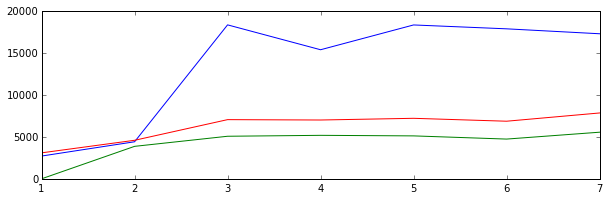

In [54]:
plt.figure(figsize=(10,3))
plt.plot(dates,countsm, color='blue')
plt.plot(dates,countsn, color='green')
plt.plot(dates,countse, color='red')

Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

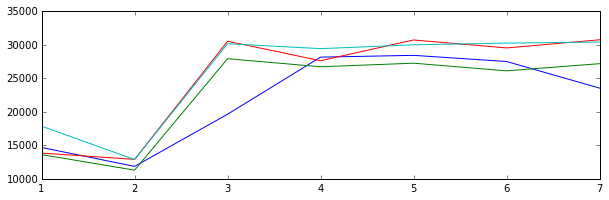

In [55]:
dates=[1,2,3,4,5,6,7]

counts1=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141018.txt'))))))))

counts2=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_150110.txt'))))))))

counts3=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt'))))))))

counts4=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141220.txt'))))))))

plt.figure(figsize=(10,3))
plt.plot(dates,counts1)
plt.plot(dates,counts2)
plt.plot(dates,counts3)
plt.plot(dates,counts4)

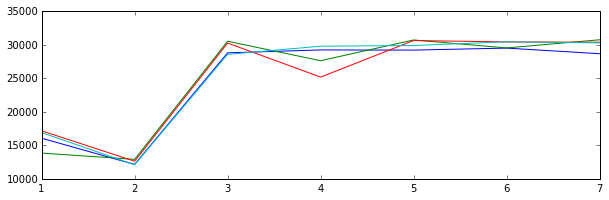

In [56]:
dates=[1,2,3,4,5,6,7]

counts1=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141101.txt'))))))))

counts2=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt'))))))))

counts3=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141115.txt'))))))))

counts4=station_count2list(station_count(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141122.txt'))))))))

plt.figure(figsize=(10,3))
plt.plot(dates,counts1)
plt.plot(dates,counts2)
plt.plot(dates,counts3)
plt.plot(dates,counts4)

In [57]:
d1= station_weekcount(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141101.txt')))))))
d2= station_weekcount(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141108.txt')))))))
d3= station_weekcount(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141115.txt')))))))
d4= station_weekcount(aggregate_count(keep_station(keep_diff(fill_min_max(extend_d(load_turnstile_file('turnstile_141122.txt')))))))

Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [58]:
sorted_d1 = sorted(d1.items(), key=operator.itemgetter(1))
print sorted_d1[350:]

[('PATH WTC', 230104), ('W 4 ST-WASH SQ', 235950), ('145 ST', 236173), ('LEXINGTON-53 ST', 243107), ('GROVE STREET', 246475), ('77 ST', 250046), ('JAY ST-METROTEC', 253341), ('14 ST', 255697), ('JAMAICA CENTER', 256465), ('BARCLAYS CENTER', 271981), ('50 ST', 277749), ('WALL ST', 284185), ('ROOSEVELT AVE', 294613), ('72 ST', 304716), ('47-50 ST-ROCK', 316219), ('MAIN ST', 359698), ('59 ST', 366449), ('23 ST', 402759), ('CANAL ST', 411394), ('CHAMBERS ST', 414954), ('FULTON ST', 424654), ('59 ST-COLUMBUS', 424784), ('96 ST', 464841), ('125 ST', 507787), ('42 ST-TIMES SQ', 534275), ('42 ST-PA BUS TE', 572339), ('14 ST-UNION SQ', 646295), ('86 ST', 655437), ('34 ST-HERALD SQ', 678610), ('42 ST-GRD CNTRL', 833260), ('34 ST-PENN STA', 1026642)]


In [59]:
d={}
for x,y in d1.items():
    d[x]=y+d2[x]+d3[x]+d4[x]
    
sorted_d = sorted(d.items(), key=operator.itemgetter(1))

print sorted_d[350:]

[('42 ST-BRYANT PK', 923064), ('CHURCH AVE', 926261), ('BOROUGH HALL/CT', 942163), ('145 ST', 961730), ('77 ST', 982905), ('JAMAICA CENTER', 1035962), ('LEXINGTON-53 ST', 1046754), ('14 ST', 1051173), ('JAY ST-METROTEC', 1063847), ('WALL ST', 1131397), ('BARCLAYS CENTER', 1132182), ('72 ST', 1196479), ('50 ST', 1199573), ('ROOSEVELT AVE', 1215277), ('47-50 ST-ROCK', 1380020), ('MAIN ST', 1474695), ('59 ST', 1572208), ('CANAL ST', 1588636), ('23 ST', 1616558), ('FULTON ST', 1670921), ('CHAMBERS ST', 1720315), ('59 ST-COLUMBUS', 1866056), ('96 ST', 1903673), ('125 ST', 2000267), ('42 ST-TIMES SQ', 2309378), ('42 ST-PA BUS TE', 2363820), ('14 ST-UNION SQ', 2403178), ('86 ST', 2742582), ('34 ST-HERALD SQ', 2962153), ('42 ST-GRD CNTRL', 3466958), ('34 ST-PENN STA', 4224665)]


Make a single list of these total ridership values and plot it to get an idea about the distribution of total ridership among different stations. This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

Additional Hint: 
If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,...

(array([ 26.,  19.,  12.,   9.,   5.,   2.,   3.,   1.,   2.,   2.]),
 array([   12987. ,   124906.5,   236826. ,   348745.5,   460665. ,
          572584.5,   684504. ,   796423.5,   908343. ,  1020262.5,
         1132182. ]),
 <a list of 10 Patch objects>)

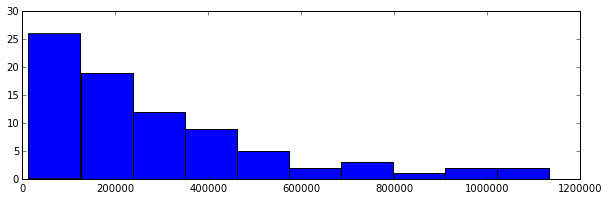

In [60]:
total_ridership_counts = [x for y,x in d.items()]
plt.figure(figsize=(10,3))
plt.hist(total_ridership_counts[:-300])

<Container object of 381 artists>

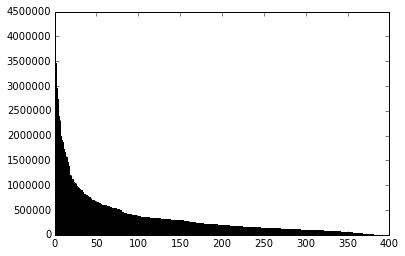

In [61]:
total_ridership_values = sorted(total_ridership_counts, reverse=True)
indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)